Import the library

In [1]:
from motorAccelerationPlanner import ArbitraryPositionChangePlan, Limits, State

Define the limits

In [2]:
limits = Limits(
    speed = 30,
    accel = 10,
    deccel = 20,
)

Compute the rectangles

In [3]:
# Define the current state of the motor
current = State(
    position=-10,
    speed=-10
)

# Define the desired state of the motor
target = State(
    position=90,
    speed=-20
)

# Compute the rectangles
plan = ArbitraryPositionChangePlan.compute(
    current,
    target,
    limits
)
print(plan)
print("analytical", "S", plan.position(limits, current))

ArbitraryPositionChangePlan(sign=1, plan=PositiveSpeedPositionChangePlan(tAccel=3.0, tSteady=1.8333333333333333, tDeccel=1.5), tPreDeccel=0.5, tPostAccel=2.0)
analytical S 90.0


Finite differences time domain simulation of the process

In [4]:
import numpy as np

class FDTD:
    __slots__ = ("aS", "vs", "ps", "ts")
    def __init__(self, current: State, plan: ArbitraryPositionChangePlan):
        v = current.speed
        S = current.position
        count = 230000
        T = plan.tTotal
        dt = T/count
        self.aS = np.zeros(count)
        self.vs = np.zeros(count)
        self.ps = np.zeros(count)
        self.ts = np.linspace(0, T, count)

        for i, t in enumerate(self.ts):
            a = plan.accel(t, limits)
            self.aS[i] = a
            v += a * dt
            self.vs[i] = v
            S += v * dt
            self.ps[i] = S

sim = FDTD(current, plan)
print("numerical", "S", sim.ps[-1], "V", sim.vs[-1])
print("analytical", "S", plan.position(limits, current), "V", plan.finalSpeed(limits, current))

numerical S 89.99389976577214 V -20.000485507246733
analytical S 90.0 V -20.0


You can get the final values given the initial values and the computed plan

In [5]:
plan.position(limits, current)

90.0

Visualize the results

State(position=-10, speed=-10) State(position=90, speed=-20)


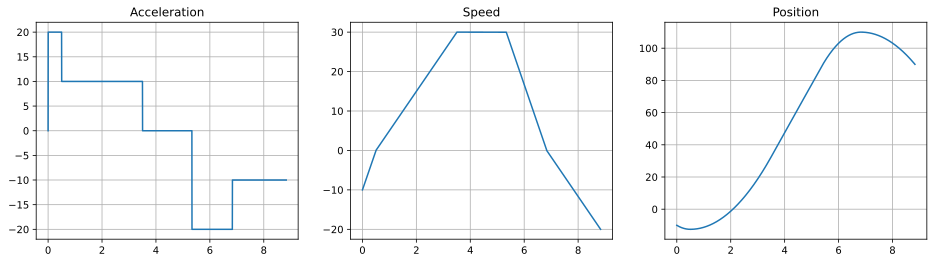

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plotSimulationResults(sim):
    fig, (aAx, spAx, posAx) = plt.subplots(1, 3, figsize=(16, 4))

    aAx.plot(sim.ts, sim.aS)
    aAx.grid()
    aAx.set_title("Acceleration")

    spAx.plot(sim.ts, sim.vs)
    spAx.grid()
    spAx.set_title("Speed")

    posAx.plot(sim.ts, sim.ps)
    posAx.grid()
    posAx.set_title("Position")

    plt.show()

print(current, target)
plotSimulationResults(sim)

On the plot we can see
1. First the motor has to deccelerate from negative speed to the rest.
2. Second it moves to the point by the optimal schedule, compensating for the time it has spent on the maneuvours.
    a. it accelerates from rest to the maximum allowed speed
    b. it moves with the maximum allowed speed
    c. it decellerates to resting state
3. Then it accelerates to the target negative speed again.

Note the overshot of the desired position. It is ineitable when the desired target speed has different sign to the movement. Let's see what happens if we don't have to do these through-zero-speed maneuvours.

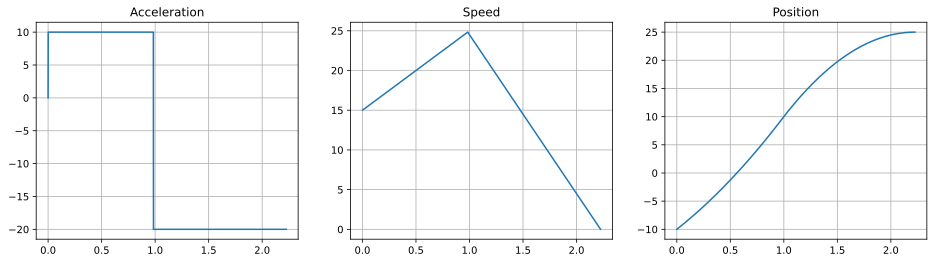

In [7]:
current=State(-10, 15)
plan = ArbitraryPositionChangePlan.compute(current, State(25, 0), limits)
sim = FDTD(current, plan)
plotSimulationResults(sim)

Here the constant speed segment is not present because the acceleration limit hasn't allowed the system to accelerate to its maximum allowed speed.